**Differential Expression Analysis**  
In this exercise we are going to look at RNA-seq data from Lung biopsies flowcellsorted into CD4 positive cells. Some of the files that we will use have been pre-constructed by us ahead of the lab because it would take too much time to do it during the lab.  
  
*DESeq*  
The DESeq approach identifies differentially expressed genes based on counts of the number of reads mapped to each gene. DESeq is not limited to RNA-seq, but can be used for comparisons of other count-based data, such gene expression profiles from tag sequencing or data from ChIP-seq experiments.

The DESeq method is implemented in the R packages DESeq and DESeq2. The latter is more recent, and recommended. The DESeq2 package is also available in several versions, tied to different versions of R (this applies to all Bioconductor packages). To use the most recent version of DESeq2, make sure you have the most recent R version installed. Also note that DESeq2 strictly requires R version 3.0 or above.

For this exercise we have pre-calculated read counts per gene  
  
---

In [1]:
library(DESeq2) # load the DESeq2 package

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which

We are now ready to read data into our session. We are reading from text files which are tab delimited. The data we need are gene counts with corresponding sample info and gene info

In [3]:
counts <- read.delim("data/counts.txt", sep="\t", check.names=FALSE, as.is=TRUE)
head(counts, n=5)

,6a,8a,B1,B13,B14,B17,B18,B2,B5,B6
ENSG00000000003,10,0,3,2,16,10,0,9,14,2
ENSG00000000419,158,193,181,166,271,192,86,196,135,186
ENSG00000000457,276,280,219,259,424,366,326,445,195,286
ENSG00000000460,52,70,38,58,71,91,50,94,27,63
ENSG00000000938,104,38,575,487,83,346,64,139,694,201


This is the count matrix. Each row is a gene and each column is a sample. The gene id is an ensembl gene id (**ENSG** *ENS (ensembl) G (gene))*  
We usually carry some more information about each gene. In this example we are going to load the *gene biotype* and the *gene name* which we have recorded in a separate file.  
You may want to look at the table with commands like `head(counts)` 


In [4]:
feature.info <- read.delim("data/feature_info.txt", sep="\t", row.names=1, check.names=FALSE) 
head(feature.info, n=5)

,gene_name,gene_biotype
ENSG00000000003,TSPAN6,protein_coding
ENSG00000000419,DPM1,protein_coding
ENSG00000000457,SCYL3,protein_coding
ENSG00000000460,C1orf112,protein_coding
ENSG00000000938,FGR,protein_coding


Lets look at the genes with highest abundance to make sure that we do no thave some molecules that dominates the total count

In [5]:
gene.sum <- rowSums(counts)
top.abundant.genes <- rownames(counts)[order(-gene.sum)[1:10]]
abundance <- data.frame(feature.info[top.abundant.genes,], Total_Reads=gene.sum[top.abundant.genes], Fraction=100*(gene.sum/sum(gene.sum))[top.abundant.genes])

In [6]:
abundance

,gene_name,gene_biotype,Total_Reads,Fraction
ENSG00000210082,MT-RNR2,Mt_rRNA,3334794,2.6890050
ENSG00000156508,EEF1A1,protein_coding,2405694,1.9398269
ENSG00000198804,MT-CO1,protein_coding,1846076,1.4885800
ENSG00000211459,MT-RNR1,Mt_rRNA,1340327,1.0807702
ENSG00000150991,UBC,protein_coding,925433,0.7462212
ENSG00000075624,ACTB,protein_coding,907072,0.7314158
ENSG00000133112,TPT1,protein_coding,853724,0.6883988
ENSG00000166710,B2M,protein_coding,652559,0.5261897
ENSG00000167996,FTH1,protein_coding,583252,0.4703042
ENSG00000234745,HLA-B,protein_coding,518243,0.4178843


  
Next, you need to create a table with information about the samples.  
The option `check.names=FALSE` is set to let R accept invalid column names. Can you guess which column names are invalid?

In [7]:
sample.info <- read.delim("data/sample_info.txt", sep="\t", check.names=FALSE)

In [8]:
sample.info$Sample_Group <- factor(sample.info$Sample_Group, levels=c("Control", "Cancer"))

Look at the content of the data frame that you created.  
The rownames should match the column names of the count matrix.  The information we need to do our statistical model is `Sample_Group`. As you can se we have explicitly defined `Sample_Group` to be a factor with two levels and ensured that our reference level is the first level.  
The other columns are not important but may be used in quality control. `Concentration` is the initial amount of RNA delivered to the lab and `260_280` and `260_230` are the Nanodrop quality measures.  

Now it’s time to construct the data set object that DESeq2 needs to perform the analysis:  

In [9]:
de <- DESeqDataSetFromMatrix(as.matrix(round(counts)), colData = sample.info, rowData=feature.info, design=~Sample_Group)

converting counts to integer mode


This function call constructs a DESeq2 data set object using the arguments we provide: (1) count table; (2) sample description, (3) gene description and (4) experimental design. All but the `rowData` arguments are mandatory. The design is specified as a `formula` (another type of R object). In this case the formula is easy: ~Sample_Group which is the factor that seprates Cancer samples from their Controls.  
  
Now that we are set, we can proceed with the differential expression testing:

In [10]:
de <- DESeq(de)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


This very simple function call does all the hard work. Briefly, this function performs three things:  
1. Compute a scaling factor for each sample to account for differences in read depth and complexity between samples
2. Estimate the variance among samples
3. Test for differences in expression among groups (Cancer vs Control in our case)  

For more details, you can always see the manual page for the function which you can do for any function by putting a question mark before the function name: ?DESeq

In [11]:
#?DESeq

Now we just need to extract the results. In more complex statistical designs you need to feed this with the specific contrasts you are looking for but in our case we can only look at the differentail expression between Cancer and Controls. 

In [12]:
res.cd4 <- results(de)
res.cd4

log2 fold change (MLE): Sample Group Cancer vs Control 
Wald test p-value: Sample Group Cancer vs Control 
DataFrame with 23656 rows and 6 columns
                  baseMean log2FoldChange     lfcSE        stat         pvalue         padj
                 <numeric>      <numeric> <numeric>   <numeric>      <numeric>    <numeric>
ENSG00000000003   6.206133    -0.71622291 1.0756514  -0.6658504 0.505506741602 0.7909429795
ENSG00000000419 172.640934     0.09254049 0.2702704   0.3423997 0.732050146915 0.9047587181
ENSG00000000457 298.432930     0.36488899 0.1866736   1.9546901 0.050619657409 0.2418138142
ENSG00000000460  59.511220     0.36142913 0.3248518   1.1125969 0.265881580319 0.5965891890
ENSG00000000938 274.475639    -2.20351360 0.4727723  -4.6608350 0.000003149292 0.0001797696
...                    ...            ...       ...         ...            ...          ...
ENSG00000285476  11.452112     0.20446359 1.0576544  0.19331796     0.84670996    0.9490899
ENSG00000285480   3.21635

  
  We are also going to shrink our log fold changes. DESeq2 uses shrinkage estimation of variances and fold changes to improve stability and interpretation of estimates.

In [13]:
lfc.cd4 <- lfcShrink(de, contrast=c("Sample_Group","Cancer","Control"), res=res.cd4)

In [14]:
lfc.cd4

log2 fold change (MAP): Sample_Group Cancer vs Control 
Wald test p-value: Sample Group Cancer vs Control 
DataFrame with 23656 rows and 6 columns
                  baseMean log2FoldChange     lfcSE        stat         pvalue         padj
                 <numeric>      <numeric> <numeric>   <numeric>      <numeric>    <numeric>
ENSG00000000003   6.206133    -0.33122847 0.4966114  -0.6658504 0.505506741602 0.7909429795
ENSG00000000419 172.640934     0.08619298 0.2517342   0.3423997 0.732050146915 0.9047587181
ENSG00000000457 298.432930     0.35251235 0.1803345   1.9546901 0.050619657409 0.2418138142
ENSG00000000460  59.511220     0.32671369 0.2935884   1.1125969 0.265881580319 0.5965891890
ENSG00000000938 274.475639    -1.79647844 0.3855930  -4.6608350 0.000003149292 0.0001797696
...                    ...            ...       ...         ...            ...          ...
ENSG00000285476  11.452112     0.09606628 0.4971187  0.19331796     0.84670996    0.9490899
ENSG00000285480   3.21635

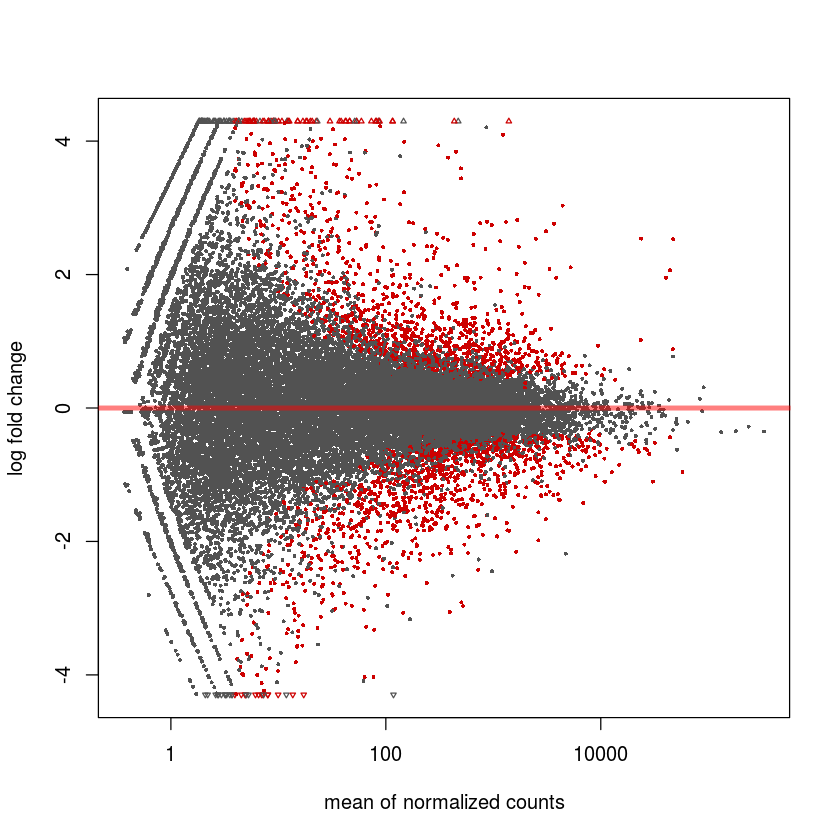

In [15]:
plotMA(res.cd4)

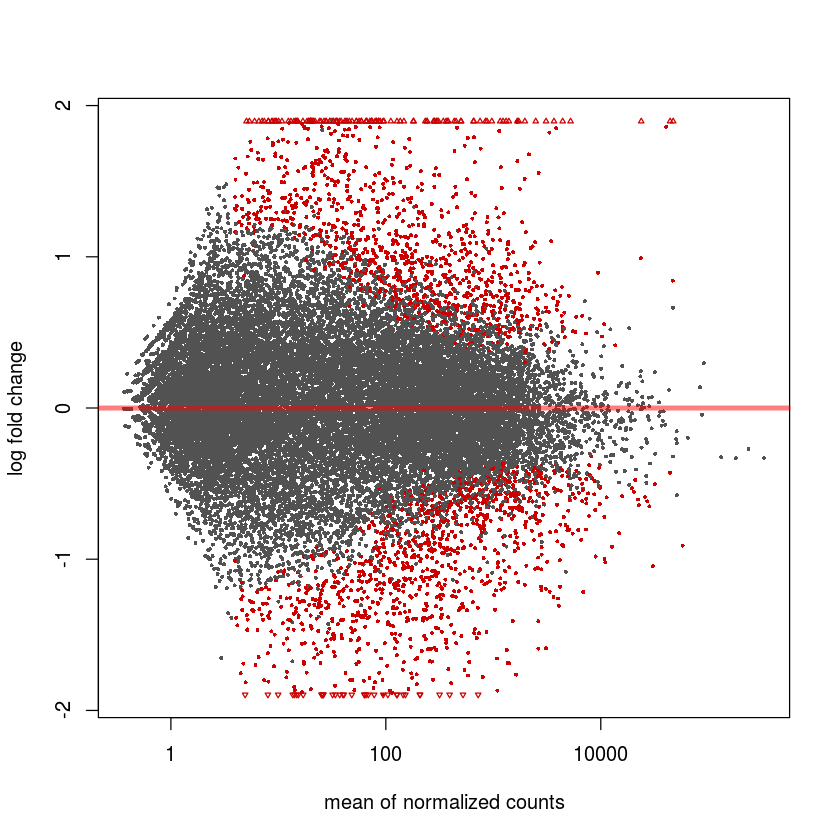

In [16]:
plotMA(lfc.cd4)

In [17]:
head(lfc.cd4, n=5)

log2 fold change (MAP): Sample_Group Cancer vs Control 
Wald test p-value: Sample Group Cancer vs Control 
DataFrame with 5 rows and 6 columns
                  baseMean log2FoldChange     lfcSE       stat         pvalue         padj
                 <numeric>      <numeric> <numeric>  <numeric>      <numeric>    <numeric>
ENSG00000000003   6.206133    -0.33122847 0.4966114 -0.6658504 0.505506741602 0.7909429795
ENSG00000000419 172.640934     0.08619298 0.2517342  0.3423997 0.732050146915 0.9047587181
ENSG00000000457 298.432930     0.35251235 0.1803345  1.9546901 0.050619657409 0.2418138142
ENSG00000000460  59.511220     0.32671369 0.2935884  1.1125969 0.265881580319 0.5965891890
ENSG00000000938 274.475639    -1.79647844 0.3855930 -4.6608350 0.000003149292 0.0001797696

The object lfc.cd4 is now a table with test results for each gene in the original count table, i.e. all annotated genes, both protein-coding and non-coding. Use the function head() to inspect the results table.

Do you understand what the columns mean? You can see information such as the “base mean” (an average of the normalized mean counts), the log2 fold change between the groups, and the P-values (both “raw” and adjusted for multiple comparisons). If you are unsure how to interpret these data, discuss with one of the students or instructor.

You probably want to focus on genes that are significant according to some criterion, such as false discovery rate (FDR) or log fold change. Filtering on the adjusted P-value (column padj) is equivalent to choosing a desired false discovery rate. For example, we can filter the results such that 1% are expected to be false positives (genes with no actual difference in expression). Let us sort on P-value and then subset :



In [18]:
lfc.cd4 <- lfc.cd4[order(lfc.cd4$pvalue),]
head(lfc.cd4, n=5)

log2 fold change (MAP): Sample_Group Cancer vs Control 
Wald test p-value: Sample Group Cancer vs Control 
DataFrame with 5 rows and 6 columns
                  baseMean log2FoldChange     lfcSE      stat       pvalue         padj
                 <numeric>      <numeric> <numeric> <numeric>    <numeric>    <numeric>
ENSG00000091972  308.88085       3.655514 0.2549227  14.24852 4.578529e-46 8.232652e-42
ENSG00000187601  502.70770       3.161066 0.2713160  11.62730 2.994322e-31 2.692045e-27
ENSG00000235304   82.04318       4.885393 0.3725763  11.40383 4.001298e-30 2.398245e-26
ENSG00000125538 1089.90272      -1.868674 0.1713032 -10.90638 1.074530e-27 4.830280e-24
ENSG00000003147  449.93853       3.382331 0.3211397  10.50644 8.068215e-26 2.901491e-22

In [19]:
sig.cd4 <- subset(lfc.cd4, padj < 0.01 & abs(log2FoldChange) > 1)

In [20]:
sig.cd4 

log2 fold change (MAP): Sample_Group Cancer vs Control 
Wald test p-value: Sample Group Cancer vs Control 
DataFrame with 668 rows and 6 columns
                  baseMean log2FoldChange     lfcSE      stat       pvalue         padj
                 <numeric>      <numeric> <numeric> <numeric>    <numeric>    <numeric>
ENSG00000091972  308.88085       3.655514 0.2549227  14.24852 4.578529e-46 8.232652e-42
ENSG00000187601  502.70770       3.161066 0.2713160  11.62730 2.994322e-31 2.692045e-27
ENSG00000235304   82.04318       4.885393 0.3725763  11.40383 4.001298e-30 2.398245e-26
ENSG00000125538 1089.90272      -1.868674 0.1713032 -10.90638 1.074530e-27 4.830280e-24
ENSG00000003147  449.93853       3.382331 0.3211397  10.50644 8.068215e-26 2.901491e-22
...                    ...            ...       ...       ...          ...          ...
ENSG00000197872 292.702167      -1.311279 0.3775246 -3.473856 0.0005130356  0.009885840
ENSG00000152229 334.911443      -1.044457 0.3006819 -3.473610 0

How many significantly differentially expressed genes do you get? 


The gene identifiers we work with above are Ensembl gene IDs. These are useful as unique identifiers, but does not tell us anything about what the genes do so lets add the feature info. We also convert the table to a data frame, so that we can manipulate and view it more easily:

In [21]:
r.cd4 <- cbind(rowData(de[rownames(sig.cd4),])[,c("gene_name", "gene_biotype")], sig.cd4)
r.cd4 <- as.data.frame(r.cd4)
rownames(r.cd4) <- rownames(sig.cd4)
head(r.cd4, n=15)

,gene_name,gene_biotype,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000091972,CD200,protein_coding,308.88085,3.655514,0.2549227,14.248525,4.578529e-46,8.232652e-42
ENSG00000187601,MAGEH1,protein_coding,502.70770,3.161066,0.2713160,11.627296,2.994322e-31,2.692045e-27
ENSG00000235304,LINC01281,lincRNA,82.04318,4.885393,0.3725763,11.403828,4.001298e-30,2.398245e-26
ENSG00000125538,IL1B,protein_coding,1089.90272,-1.868674,0.1713032,-10.906378,1.074530e-27,4.830280e-24
ENSG00000003147,ICA1,protein_coding,449.93853,3.382331,0.3211397,10.506440,8.068215e-26,2.901491e-22
ENSG00000149257,SERPINH1,protein_coding,1233.86635,3.537105,0.3401214,10.401545,2.439450e-25,7.310624e-22
ENSG00000030419,IKZF2,protein_coding,1314.71701,2.590543,0.2551870,10.148074,3.379669e-24,8.681404e-21
ENSG00000173110,HSPA6,protein_coding,4420.55166,2.762887,0.2838556,9.734343,2.152030e-22,4.836956e-19
ENSG00000172817,CYP7B1,protein_coding,53.30352,3.710941,0.3696286,9.507223,1.958208e-21,3.912282e-18
ENSG00000140403,DNAJA4,protein_coding,3095.45820,2.434909,0.2704508,9.003025,2.195830e-19,3.948322e-16


We can visualize the countdata usin the `plotCounts` function in the DESeq2 package. The keyword `intgroup` needs to be a sample info column name which decides the x-axis.  
You can try changing the ENSEMBL ID and look at different genes.

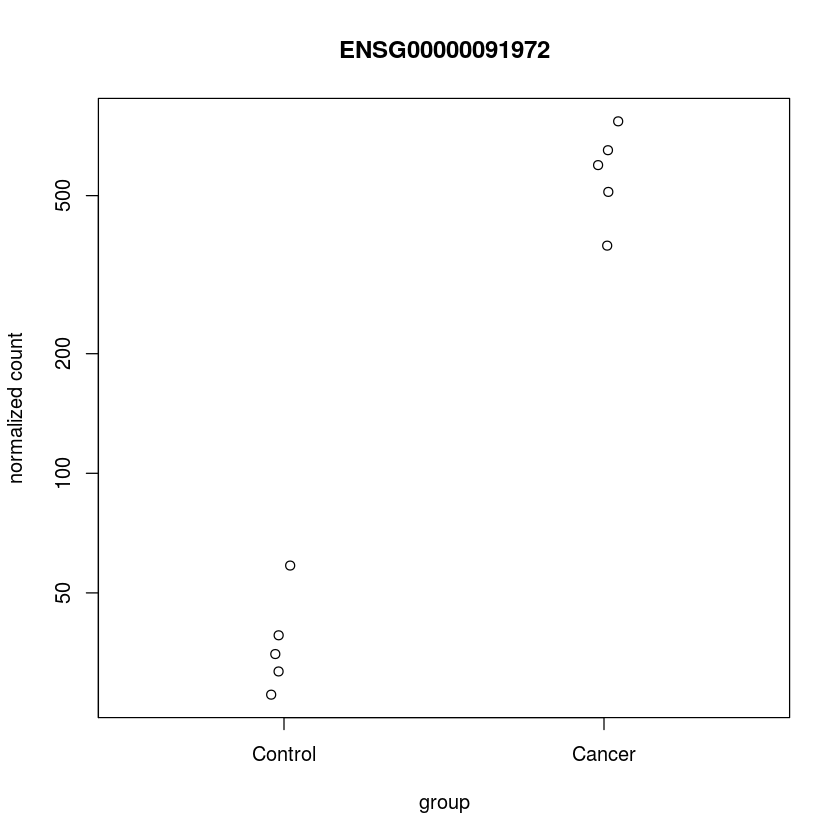

In [22]:
plotCounts(de, "ENSG00000091972", intgroup="Sample_Group")

Check your p-value histogram. Details at http://varianceexplained.org/statistics/interpreting-pvalue-histogram/ . 

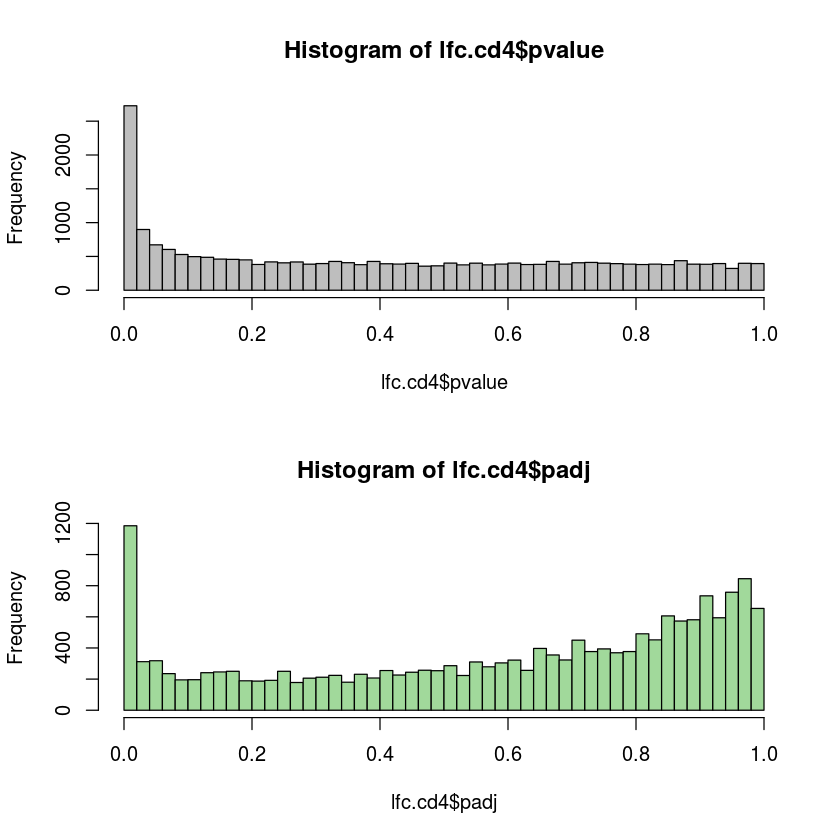

In [24]:
par(mfrow=c(2,1))
hist(lfc.cd4$pvalue, breaks=50, col="grey")
hist(lfc.cd4$padj, breaks=50, col="#a1d99b") #FDR adjusted p-values


We can also look at p-values vs fold change. This is often refered to as a volcano plot.  

We look at all genes here, but you can substitute lfc.cd4 with for instance r.cd4 to look at what you have called significant

In [25]:
## Volcano plot 
volcanoplot <- function (res, lfcthresh=2, sigthresh=0.05, main="Volcano Plot", legendpos="bottomright", labelsig=TRUE, textcx=1, ...) {
  with(res, plot(log2FoldChange, -log10(pvalue), pch=20, main=main, ...))
  with(subset(res, padj<sigthresh ), points(log2FoldChange, -log10(pvalue), pch=20, col="red", ...))
  with(subset(res, abs(log2FoldChange)>lfcthresh), points(log2FoldChange, -log10(pvalue), pch=20, col="orange", ...))
  with(subset(res, padj<sigthresh & abs(log2FoldChange)>lfcthresh), points(log2FoldChange, -log10(pvalue), pch=20, col="green", ...))
  if (labelsig) {
    require(calibrate)
    with(subset(res, padj<sigthresh & abs(log2FoldChange)>lfcthresh), textxy(log2FoldChange, -log10(pvalue), labs=Gene, cex=textcx, ...))
  }
  legend(legendpos, xjust=1, yjust=1, legend=c(paste("FDR<",sigthresh,sep=""), paste("|LogFC|>",lfcthresh,sep=""), "both"), pch=20, col=c("red","orange","green"))
}

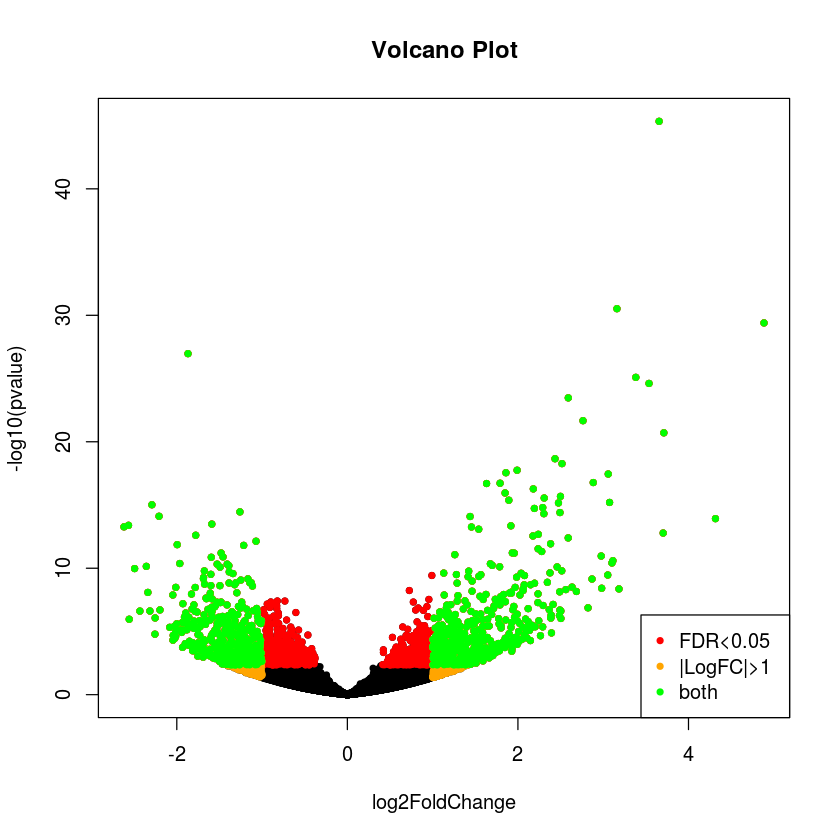

In [26]:
volcanoplot(lfc.cd4, labelsig=FALSE, lfcthresh=1, sigthresh=0.05)  

The final step is ta save your result to a file.

In [27]:
write.table(r.cd4, file="data/diffexpr-results.csv", sep="\t", quote=FALSE)